# Background Knowledge:

As a species, we are surprisingly fragile in the face of natural perils like hailstorms, floods, and high winds.  As a result, we have developed the built environment to largely separate us from normal variations in temperature, atmospheric pressure, wind, rain, and lightning.  However, the use of the phrase "normal" variations should underscore the statistical nature of these phenomenon.  Every year, natural disasters occur on every continent on this planet.  Many go unnoticed, as they occur in undeveloped regions on the planet.  However, when these events do intersect with the built environment, they test the limitations of our infrastructure.  Hurricanes, floods, earthquakes, and many other natural perils significantly impact a large number of structures whenever they pass over developed regions. Due to the rarity of these events and the expense of constructing indestructable structures, buildings are rarely designed to accomodate the conditions that occur during these events.  

Most engineered structures are developed with design criterion that specifically reference the occurance rate of these events, e.g., 100 year storms, 1000 year floods, 10000 year earthquakes, etc.   Building structures to withstand stressful events requires an increase in design time and an increase in materials and labor, which ultimately creates a situation that requires a tradeoff: safety versus development cost.  From an engineering perspective, the useful lifecycle of a building can be quantified in decades, whereas the occurance rate for large natural disasters is typically quantified in centuries or even millennia.  Thus, we are really making a decision under uncertainty: what is the probability that my structure will undergo the  conditions that occur during a category five hurricane for example.  Many people look at the odds, decide their lifespan is short and wallet light, and gamble on the construction quality of their homes.  Thus, the insurance industry arose to manage the risk incurred due to optimistic construction codes and homebuyers.  

Policy makers depend on these estimates to make recommendations on building codes: i.e., the minimum structural properties required for a building to be considered safe to occupy.  However, due to the importance of these structures in our lives, people often hedge their bets by purchasing insurance against natural disasters, and in turn, the insurance companies need to quantify these event probabilies in order to price their policies correctly.  In the early eighties and nineties, these probabilities were estimated from very limited datasets.  However, with the advent of satellite imagery, sophisicated measurement devices, and large scale data collection and processing, the ability to quantify this uncertainty has improved significantly.  Entire companies have been developed who model the natural disasters using state of the art physics models, machine learning, data visualization techniques, and physical experiments.  Still, the infrequent nature of these disasters leaves much room for uncertainty, and the computational cost associated with the modeling stage makes it difficult to know if the statistics that we compute from these simulations have converged.  

Especially challenging is the fact that the scales that these events occur on vary drastically, and the insurance policies which a company wishes to sell operate on scales as small as individual houses, and as large as worldwide corporate policies.  For instance, we may be able to model the probability of having ten or more hurricanes in the Atlantic basin during a single season, but how well are we modeling the probability of a category five earthquake making landfall on a specific city along the South Carolina coastline.  The idea is that the smaller the scale that we consider, the lower the probability of an event occuring on that specific spot, and the less frequently a specific event occurs, the harder it is to estimate the probability that the event will occur.  Assessing the quality of these estimates is the purpose of this document.


## Goal: Assess Catalog Convergence:

This notebook is being developed to assess the convergence criterion for the stochastic catalogs developed by A.I.R.  This is a test dataset which is used for assessing coding skills, and does not represent actual datasets used by the company.  The data used for this exercise have been separated into several files.  These datasets need to be reduced to the relevant information for our analysis, and then joined into a single dataset for processing.  The requirements of this process are simply to be able to process the data on a single work pc with 16 GB of memory.

This document will be broken into several stages:

1. Initial data processing and queries, which consists of assessing data types and memory requirments to load in the entire dataset.

2. Loading in the parts of the dataset relevant to the computations needed, and appending the partitioned datasets into a single dataset.

3. Analyzing the datasets in chunks to produce useful plots.

4. Assessing the convergence of the plots.

This project was developed using:

1. Python 3: version 3.7.4
2. 12 GB of physical storage for the datasets (can we stream from GITHUB?)
3. Python package: Pandas 0.25.1
4. Python package: numpy  1.16.5

In [40]:
## Software Requirements
from platform import python_version
print(python_version())

import pandas as pd 
print(pd.__version__)

import numpy as np 
print(np.__version__)

from matplotlib import pyplot as plt

import glob

import time

import seaborn
print(seaborn.__version__)

%matplotlib inline

3.7.4
0.25.1
1.16.5
0.9.0


## Data Exploration

Loss statistics, i.e., how statistics that estimate much money an insurance company might lose in a single year, are estimated using mathematical models of individual natural disasters.  For example, a company may have separate models for earthquakes in the United States, typhoons in Japan, and landslides in China.  This spatial discretization is extremely necessary due to the physical nature of the events; a hurricane is extremely unlikely to occur in northern Canada compared to southern Florida in the US.  

Loss statistics are computed from stochastic catalogs, which are Monte Carlo style simulations that account for uncertainty in the model parameters: frequency of events, location of the event, magnitude of the event, etc.  To accurately estimate these statistics, we take advantage of the Law of Large numbers; whenever studying stochastic events, the larger the number of random samples you can simulate, the more confident you can be in the value of the statistics of the sample.  We require a large number of Monte Carlo samples to estimate rare event probabilities.  The approach taken in this is to generate stochastic catalogs, where a year's worth of natural disasters are simulated ten thousand to one-hundred thousand times.  

In [2]:
# dataset assumed to follow the form "./relative_path/dataset_path_prefix_%d.csv"%file_number
dataset_path_prefix = "./10K/10k_20180312_part_"

num_files = 3           # number of parts the dataset is partitioned into

num_catalog_years = 10000

In [3]:
## Do some basic analysis of the dataset using Pandas API
file_num   = 1    # we only want to read in one file for now

filename = "%s%d.csv"%(dataset_path_prefix, file_num)
cat_part_1 = pd.read_csv("%s%d.csv"%(dataset_path_prefix, file_num))

cat_part_1.info(memory_usage = 'deep')  # print out some basic information about the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763413 entries, 0 to 763412
Data columns (total 41 columns):
CatalogTypeCode       763413 non-null object
EventID               763413 non-null int64
ModelCode             763413 non-null int64
YearID                763413 non-null int64
LobSID                763413 non-null int64
UserLineOfBusiness    763413 non-null int64
CountryCode           763413 non-null int64
CrestaCode            763413 non-null int64
GroundUpLoss          763413 non-null float64
GroundUpSD            763413 non-null float64
GroundUpMaxLoss       763413 non-null float64
GroundUpLoss_A        763413 non-null float64
GroundUpSD_A          763413 non-null float64
GroundUpMaxLoss_A     763413 non-null float64
GroundUpLoss_B        763413 non-null int64
GroundUpSD_B          763413 non-null int64
GroundUpMaxLoss_B     763413 non-null int64
GroundUpLoss_C        763413 non-null float64
GroundUpSD_C          763413 non-null float64
GroundUpMaxLoss_C     763413 non-nul

Looking at the output of the DataFrame.info() call, we can see that the memory usage for part 1 of the dataframe is 276.7 MB.  This is not too bad for one file, and we only have three files for the 10K catalog.  However, for the 100K catalog, we have 100 files.  If they are the same size, this will be a massive use of memory whenever we read in the entire dataset.  Lets look at some ways to reduce this memory consumption.  

The first is to consider what we need for our analysis.  Our first goal is to construct a year loss table, which consists of two columns: the YearID, and the GoundUpLoss.  There are 10K years in this DataFrame, but 763413 rows which each have a year.  Therefore, there must be multiple entries per year in the catalog.  Thus, we will likely be summing all of the losses for individual years.  

Our second goal is actually just repetitions of the first goal.  We want to study convergence of the catalog based on location.  I.e., how does the convergence vary with spatial resolution.  Remember, earlier we mentioned that some insurance companies only sell policies to specific regions.  Therefore they do not care about convergence globally, they care about convergence of the catalog in the regions which they insure.  Thus, we will need to be able to partition this dataset by region.  The two columns that give us location based information are "CrestaCode" and "CountryCode".  Lets select a subset of our  data.



In [4]:
columns_to_keep = ["YearID", "CountryCode", "CrestaCode"]

cat_part_1_reduced = cat_part_1.loc[:, columns_to_keep]

cat_part_1_reduced.head()

,YearID,CountryCode,CrestaCode
0,1,1,48171
1,1,1,48171
2,1,1,35009
3,1,1,35009
4,1,1,40021


In [5]:
cat_part_1_reduced.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763413 entries, 0 to 763412
Data columns (total 3 columns):
YearID         763413 non-null int64
CountryCode    763413 non-null int64
CrestaCode     763413 non-null int64
dtypes: int64(3)
memory usage: 17.5 MB


So, knowing what we want to do with our analysis, we have reduced the size of a single dataset from ~280 MB per file to 17.5MB per file.  This could still be large if the catalog size grows much larger, and there are still some optimizations that we might be able to take advantage of.  Specifically, the datatypes are int64, which is the largest int type that we could use.  Lets take a look and see if we can downcast those types to something that is more memory efficient.

In [6]:
cat_part_1_reduced.describe()

,YearID,CountryCode,CrestaCode
count,763413.000000,763413.0,763413.000000
mean,1498.934315,1.0,26575.889114
std,867.109178,0.0,19073.176333
min,1.000000,1.0,4001.000000
25%,753.000000,1.0,6069.000000
50%,1496.000000,1.0,30095.000000
75%,2253.000000,1.0,41045.000000
max,3000.000000,1.0,56045.000000


Note: the country codes are all the same, indicating that all of these locations are in the United States.  Thus, this column is not providing much information.  Secondly, CrestaCode takes only positive values, and the values are never larger than five digits.  The year ID is similarly limited to positive values and we know that it takes values between 1 and the number of catalog years (either 10K or 100K in this example).  We should be able to downcast these datatypes to more efficient types.



In [7]:
cat_part_1_reduced = cat_part_1_reduced.drop("CountryCode", axis = 1)  # remove the CountryCode column

cat_part_1_reduced = cat_part_1_reduced.apply(pd.to_numeric, downcast = 'unsigned')

cat_part_1_reduced.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763413 entries, 0 to 763412
Data columns (total 2 columns):
YearID        763413 non-null uint16
CrestaCode    763413 non-null uint16
dtypes: uint16(2)
memory usage: 2.9 MB


Now we have reduced the dataset from ~280 MB down to 2.9 MB per file.  Now, we are going to want to be able to states and counties, which is the information that the CrestaCode gives us.  These are five digit numbers, where the first two numbers are the state code, and the last three numbers are the county code.  Unfortunately, when they are represented as unsigned integers, some of the values only have four digits because the leading zeros are dropped.

Let us create a new column that contains the state codes from the CrestaCode block.

In [8]:
cat_part_1_reduced["StateID"] = cat_part_1_reduced["CrestaCode"].astype(str).apply(lambda x: x.zfill(5))

print(cat_part_1_reduced["StateID"].describe())

print(cat_part_1_reduced.dtypes)

print(cat_part_1_reduced.info(memory_usage = "deep"))

count     763413
unique       741
top        06065
freq       26963
Name: StateID, dtype: object
YearID        uint16
CrestaCode    uint16
StateID       object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763413 entries, 0 to 763412
Data columns (total 3 columns):
YearID        763413 non-null uint16
CrestaCode    763413 non-null uint16
StateID       763413 non-null object
dtypes: object(1), uint16(2)
memory usage: 48.1 MB
None


Now we have increased the size dramatically by introducing a column of objects.  Note that there are only 741 unique values in the StateID column.  Lets remove the last three digits of the CrestaCodes contained in StateID, and then convert back to unsigned integers to save space.

In [9]:
cat_part_1_reduced["StateID"] = pd.to_numeric(cat_part_1_reduced["StateID"].apply(lambda x: x[0:2]), downcast = 'unsigned')

print(cat_part_1_reduced["StateID"].describe())

print(cat_part_1_reduced.info(memory_usage = 'deep'))

count    763413.000000
mean         26.497213
std          19.044647
min           4.000000
25%           6.000000
50%          30.000000
75%          41.000000
max          56.000000
Name: StateID, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763413 entries, 0 to 763412
Data columns (total 3 columns):
YearID        763413 non-null uint16
CrestaCode    763413 non-null uint16
StateID       763413 non-null uint8
dtypes: uint16(2), uint8(1)
memory usage: 3.6 MB
None


In the above cell we removed the final three values of the cresta code, which denotes the county values.  That provided us with a Series of strings that contained the state code.  Since Pandas represents strings as object types, the memory usage is much higher than necessary to represent unsigned, two digit integers.  Thus, we also converted the strings to numeric and downcast them to uint8, which is one of the most memory efficient types that we can use.

Now, we need to do this for every file in our dataset, so lets write a function to do the repetitive task.

In [10]:
def read_and_reduce_dataset(filename):
    columns_to_keep = ["YearID", "CrestaCode", "GroundUpLoss"]
    
    dataset = pd.read_csv(filename, usecols = columns_to_keep)
    dataset = dataset.apply(pd.to_numeric, downcast = 'unsigned')
    
    dataset["StateID"] = dataset.loc[:, "CrestaCode"].astype(str).apply(lambda x: x.zfill(5))
    dataset.loc[:,"StateID"] = pd.to_numeric(dataset.loc[:,"StateID"].apply(lambda x: x[0:2]), downcast = 'unsigned')
    return(dataset)

In [11]:
start_time = time.time()
new_dataset = read_and_reduce_dataset(filename)
print("Reading in a single dataset takes %f seconds"%(time.time() - start_time))
print(new_dataset.info(memory_usage='deep'))
new_dataset.head()

Reading in a single dataset takes 2.189761 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763413 entries, 0 to 763412
Data columns (total 4 columns):
YearID          763413 non-null uint16
CrestaCode      763413 non-null uint16
GroundUpLoss    763413 non-null float64
StateID         763413 non-null uint8
dtypes: float64(1), uint16(2), uint8(1)
memory usage: 9.5 MB
None


,YearID,CrestaCode,GroundUpLoss,StateID
0,1,48171,3.243530e+05,48
1,1,48171,1.924000e+03,48
2,1,35009,3.854790e+02,35
3,1,35009,1.640490e+00,35
4,1,40021,1.635040e+06,40


You will notice that we added an additional column, the ground up loss.  We had not specified that column in previous steps, because I knew that I would not downcast this value.  Specifically, the ground up loss is a float64, and we will be computing statistics on the GroundUpLoss.  We do not want to lose any precision for these calculations, which can easily happen when computing standard deviations.  This is mentioned specifically in the numpy.sd documentation, which states that standard deviation calculations can be innacurate when using float32 datatypes.  Notice, we applied the downcast to the entire dataset, but the GroundUpLoss was not affected because it cannot be cast to an unsigned integer type, however it is always useful to check anyway!  Unfortunately, the addition of this single column has increased our memory usage from 3.6 MB per file to 9.5 MB per file, with a processing time of ~2.3 seconds per file.

Lets build our entire dataset.

In [12]:
fileset = ["%s%d.csv"%(dataset_path_prefix, index) for index in np.arange(1, num_files + 1)]
print(fileset)
start_time = time.time()
full_dataset = pd.concat([read_and_reduce_dataset(file) for file in fileset], ignore_index = True)
print("Reading in entire dataset takes %f seconds"%(time.time() - start_time))
print(full_dataset.info(memory_usage='deep'))

['./10K/10k_20180312_part_1.csv', './10K/10k_20180312_part_2.csv', './10K/10k_20180312_part_3.csv']
Reading in entire dataset takes 7.355976 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557951 entries, 0 to 2557950
Data columns (total 4 columns):
YearID          uint16
CrestaCode      uint16
GroundUpLoss    float64
StateID         uint8
dtypes: float64(1), uint16(2), uint8(1)
memory usage: 31.7 MB
None


## Data Analysis

Now that we can quickly read in our entire dataset into the specified form, we need to actually compute the statistics of the catalog.  Specifically, we will be generating a loss table, which aggregates all of the estimated GroundUpLosses that occur during a particular calatog year.  Since we have 10,000 catalog years in this particular catalog, the loss table will have 10K entries.  This type of analysis requires creating subsets of the original dataset, and aggregating certain parts of a particular column based on the value of another column.  In the end, we would like to convert our three column dataframe with 2557951 rows into a two column dataframe with 10K rows.  Each row should contain the sum of Ground up losses for a particular catalog year and a particular spatial resolution and location.  For example, to build a loss table for StateID = 48, we only want to sum GroundUpLosses that occur in that particular state, and ignore all others.

This is not a type of data analysis that you should perform using Numpy arithmatic, because it cannot be easily vectorized.  Instead, this is the exact situation that a pivot table was created for.  A pivot table is a small table that summarizes the results contained in a larger dataset.  These summary statistics can be any valid statistic that describes the data contained in the subset of interest.   Because we are taking a large dataset and reducing it, the statistical function we select is called the aggregation function, which is simply a way of grouping rows of a dataframe together and computing a single summary value for those rows. Pandas has an efficient implementation of pivot tables, pivot_table, that we can take advantage of.

In this example, we will create a loss table for all states.  We will index our table by the YearID, creating rows that are equal to the catalog year that particular GroundUpLosses occured in.  And we will create columns that contain the sum of all GroundUpLosses that occured in each state during a particular calendar year.

In [13]:
start_time = time.time()
loss_table_states  = pd.pivot_table(full_dataset.drop('CrestaCode', axis = 1), index = "YearID", columns = "StateID", values = "GroundUpLoss",aggfunc = np.sum)
print("Creating the pivot table with np.sum as the agg func takes %f seconds."%(time.time() - start_time))

start_time = time.time()
loss_table_states  = pd.pivot_table(full_dataset.drop('CrestaCode', axis = 1), index = "YearID", columns = "StateID", values = "GroundUpLoss",aggfunc = sum)
print("Creating the pivot table with Python's sum as the agg func takes %f seconds."%(time.time() - start_time))


Creating the pivot table with np.sum as the agg func takes 0.258962 seconds.
Creating the pivot table with Python's sum as the agg func takes 0.272007 seconds.


In [14]:
print(loss_table_states.info(memory_usage='deep'))

print(loss_table_states.describe())

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
4     9323 non-null float64
6     10000 non-null float64
8     8958 non-null float64
16    7456 non-null float64
30    8933 non-null float64
32    6894 non-null float64
35    8123 non-null float64
40    9986 non-null float64
41    8625 non-null float64
48    9881 non-null float64
49    5608 non-null float64
53    9365 non-null float64
56    8035 non-null float64
dtypes: float64(13)
memory usage: 1.1 MB
None
StateID            4             6             8             16            30  \
count    9.323000e+03  1.000000e+04  8.958000e+03  7.456000e+03  8.933000e+03   
mean     2.559206e+08  2.288897e+09  1.522426e+08  7.498234e+07  5.624960e+07   
std      7.112907e+08  3.474815e+09  5.137712e+08  3.016228e+08  1.299149e+08   
min      5.839110e-01  2.435049e+05  5.910460e-01  5.873530e-01  5.863060e-01   
25%      6.562328e+06  4.347917e+08  5.217152e+06  1.417161e+06  3.162463e

Looking at the above, the pivot table requires 1.1MB of memory to store, has 13 columns which are the 13 unique state codes contained in the dataset.  

In [15]:
loss_table_states.head()

StateID,4,6,8,16,30,32,35,40,41,48,49,53,56
YearID,,,,,,,,,,,,,
1,1.745931e+07,2.770872e+09,1.012670e+07,4.662517e+06,10220431.5,NaN,7.676548e+06,1.164236e+08,1.220875e+07,1.519489e+08,648164.16,7.127282e+08,5.996420e+06
2,1.462768e+08,3.056520e+08,NaN,5.768658e+05,NaN,NaN,1.130717e+06,1.248806e+08,NaN,3.466474e+07,NaN,2.753115e+08,1.112858e+06
3,3.193161e+07,2.405179e+08,7.516624e+02,5.527672e+05,4435315.0,3.896147e+08,9.064230e+06,5.860247e+07,5.638125e+06,9.688161e+07,17195335.60,4.139732e+07,1.111818e+08
4,1.214921e+09,6.073755e+08,3.761395e+06,1.211955e+07,NaN,NaN,3.417262e+06,4.264110e+08,2.855041e+06,6.587626e+07,NaN,3.635959e+06,6.154971e+04
5,1.871788e+07,1.815619e+09,6.287765e+07,4.079936e+08,NaN,1.055812e+06,3.892102e+07,8.725775e+06,1.730932e+07,8.909275e+06,NaN,7.730143e+07,2.277814e+05


In [16]:
loss_table_states = loss_table_states.fillna(0)          # Remove the NaN values that occur whenever an event did not occur.
loss_table_states.head()

StateID,4,6,8,16,30,32,35,40,41,48,49,53,56
YearID,,,,,,,,,,,,,
1,1.745931e+07,2.770872e+09,1.012670e+07,4.662517e+06,10220431.5,0.000000e+00,7.676548e+06,1.164236e+08,1.220875e+07,1.519489e+08,648164.16,7.127282e+08,5.996420e+06
2,1.462768e+08,3.056520e+08,0.000000e+00,5.768658e+05,0.0,0.000000e+00,1.130717e+06,1.248806e+08,0.000000e+00,3.466474e+07,0.00,2.753115e+08,1.112858e+06
3,3.193161e+07,2.405179e+08,7.516624e+02,5.527672e+05,4435315.0,3.896147e+08,9.064230e+06,5.860247e+07,5.638125e+06,9.688161e+07,17195335.60,4.139732e+07,1.111818e+08
4,1.214921e+09,6.073755e+08,3.761395e+06,1.211955e+07,0.0,0.000000e+00,3.417262e+06,4.264110e+08,2.855041e+06,6.587626e+07,0.00,3.635959e+06,6.154971e+04
5,1.871788e+07,1.815619e+09,6.287765e+07,4.079936e+08,0.0,1.055812e+06,3.892102e+07,8.725775e+06,1.730932e+07,8.909275e+06,0.00,7.730143e+07,2.277814e+05


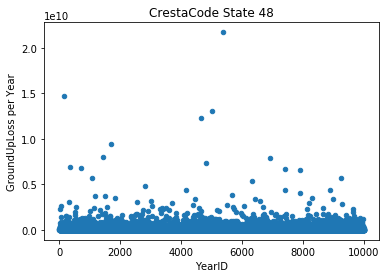

In [43]:
ax =  loss_table_states.reset_index().plot.scatter("YearID", 48)

ax.set_ylabel("GroundUpLoss per Year")
ax.set_title("CrestaCode State 48")
plt.show()

The total ground up losses per year are useful pieces of information from a Financial standpoint.  Looking at the above plot, it's easy to see that annual GroundUpLoss can be tough to interpret on their own. Thus we want to construct a function that will compute some more informative statistics for us.


In [44]:
def create_loss_statistic_table(GroundUpLossPerYear):
    num_years = len(GroundUpLossPerYear)
    column_names = ["AAL", "STD", "STDERR", "COV"] # Average Annual Loss, Cumulative Standard Deviation, Cumulative Standard Error, Cumulative Coefficient of Variation
    dataframe = pd.DataFrame(data = np.zeros([num_years, 4]), index = np.arange(1, num_years + 1), columns = column_names)
    
    dataframe.loc[:, "AAL"]    = GroundUpLossPerYear.expanding(1).mean()
    dataframe.loc[2:, "STD"]    = GroundUpLossPerYear.expanding(1).std()
    dataframe.loc[2:, "STDERR"] = dataframe.loc[2:,"STD"] / np.sqrt(np.arange(2, num_years + 1))
    dataframe.loc[2:, "COV"]    = dataframe.loc[2:,"STDERR"] / dataframe.loc[2:, "AAL"]
    
    return(dataframe.fillna(0))



In [45]:
start_time = time.time()
aal_table = create_loss_statistic_table(loss_table_states.loc[:, 48])
print("Creating AAL table takes %f seconds."%(time.time() - start_time))

print(aal_table.info(memory_usage='deep'))

aal_table.head()

Creating AAL table takes 0.015589 seconds.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
AAL       10000 non-null float64
STD       10000 non-null float64
STDERR    10000 non-null float64
COV       10000 non-null float64
dtypes: float64(4)
memory usage: 710.6 KB
None


,AAL,STD,STDERR,COV
1,1.519489e+08,0.000000e+00,0.000000e+00,0.000000
2,9.330683e+07,8.293244e+07,5.864209e+07,0.628487
3,9.449842e+07,5.867840e+07,3.387799e+07,0.358503
4,8.734288e+07,5.000243e+07,2.500122e+07,0.286242
5,7.165616e+07,5.572745e+07,2.492207e+07,0.347801


Generating the above table is extremely fast for a single state, and can be used to plot useful information about the convergence of the stochastic catalog for that particular state.  In particular, we consider a catalog to be converged at a particular year if the coefficient of variation (COV) is < 0.05. 

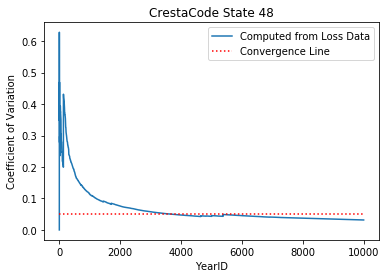

In [48]:
years = loss_table_states.reset_index().loc[:,"YearID"].to_numpy()

plt.plot(years, aal_table.COV, label = "Computed from Loss Data")

plt.plot([0, 10000], [0.05, 0.05], c = 'red', linestyle = ":", label = "Convergence Line")  # place convergence line

plt.xlabel("YearID")

plt.ylabel("Coefficient of Variation")

plt.title("CrestaCode State 48")

plt.legend()

plt.show()


In [49]:
start_time = time.time()

aal_table_set = [create_loss_statistic_table(loss_table_states.loc[:, state_num]) for state_num in loss_table_states.columns]

print("Creating all AAL table takes %f seconds."%(time.time() - start_time))

Creating all AAL table takes 0.083777 seconds.


Now we have a list of Data.Frames with identical columns and indices.  Lets concatenate them by their index number so that we can compute averages and standard deviations across all states.

In [50]:
aal_tables = pd.concat(aal_table_set) # keeps original row index
print(aal_tables.info())              # show that it keeps original row index

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130000 entries, 1 to 10000
Data columns (total 4 columns):
AAL       130000 non-null float64
STD       130000 non-null float64
STDERR    130000 non-null float64
COV       130000 non-null float64
dtypes: float64(4)
memory usage: 5.0 MB
None


Now lets group by the indices and take the average of each column.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
AAL       10000 non-null float64
STD       10000 non-null float64
STDERR    10000 non-null float64
COV       10000 non-null float64
dtypes: float64(4)
memory usage: 390.6 KB
None


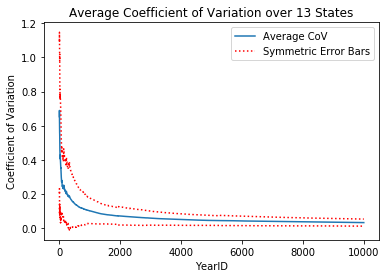

In [56]:
aal_tables_average = aal_tables.groupby(aal_tables.index).mean()
aal_tables_std     = aal_tables.groupby(aal_tables.index).std()
print(aal_tables_average.info())
plt.plot(years[3:], aal_tables_average.loc[4:,"COV"], label = "Average CoV")
plt.plot(years[3:], aal_tables_average.loc[4:,"COV"] + 2*aal_tables_std.loc[4:, "COV"], c = 'red', label = "Symmetric Error Bars", linestyle = ":")
plt.plot(years[3:], aal_tables_average.loc[4:,"COV"] - 2*aal_tables_std.loc[4:, "COV"], c = 'red', label = None, linestyle = ":")

plt.xlabel("YearID")
plt.ylabel("Coefficient of Variation")
plt.title("Average Coefficient of Variation over 13 States")
plt.legend()
plt.show()

Looking at the above plot, we can se that the stochastic catalog approaches the convergence criterion fairly quickly on average, and even the second standard deviation from the mean approaches convergence quickly as well.  However, one should be careful when thinking about this result, because the plots are unlikely to be normally distributed due to the truncation of the coefficient of variation at one and at zero.  Looking at the "error bars", we can see that these bounds are violated by the standard deviation.  Instead, let's look at the percentage of states whose catalogs have converged by a particular year.

In [57]:
aal_tables["Converged"] = aal_tables.loc[:,"COV"] < 0.05

aal_tables["Converged"] = aal_tables["Converged"].astype(int) # convert true/false to 0/1

aal_tables.loc[1, "Converged"] = 0           # the first row is not meaningful

aal_tables

,AAL,STD,STDERR,COV,Converged
1,1.745931e+07,0.000000e+00,0.000000e+00,0.000000,0
2,8.186803e+07,9.108769e+07,6.440872e+07,0.786738,0
3,6.522256e+07,7.056698e+07,4.074187e+07,0.624659,0
4,3.526471e+08,5.777293e+08,2.888647e+08,0.819132,0
5,2.858612e+08,5.221400e+08,2.335081e+08,0.816858,0
...,...,...,...,...,...
9996,3.206868e+07,1.263616e+08,1.263869e+06,0.039411,1
9997,3.206567e+07,1.263556e+08,1.263746e+06,0.039411,1
9998,3.206273e+07,1.263496e+08,1.263623e+06,0.039411,1
9999,3.206092e+07,1.263434e+08,1.263498e+06,0.039409,1


In [58]:
aal_table_grouped = aal_tables.groupby(aal_tables.index).mean()

aal_table_grouped

,AAL,STD,STDERR,COV,Converged
1,2.939209e+08,0.000000e+00,0.000000e+00,0.000000,0.000000
2,1.811761e+08,1.743787e+08,1.233044e+08,0.684941,0.153846
3,1.466049e+08,1.745471e+08,1.007748e+08,0.668564,0.000000
4,1.549620e+08,2.003918e+08,1.001959e+08,0.652877,0.000000
5,1.617798e+08,2.005383e+08,8.968345e+07,0.689452,0.000000
...,...,...,...,...,...
9996,2.674755e+08,5.496094e+08,5.497193e+06,0.031967,1.000000
9997,2.674688e+08,5.495828e+08,5.496653e+06,0.031966,1.000000
9998,2.674861e+08,5.495690e+08,5.496240e+06,0.031964,1.000000
9999,2.674802e+08,5.495440e+08,5.495715e+06,0.031963,1.000000


Text(0, 0.5, 'Percentage of States Converged')

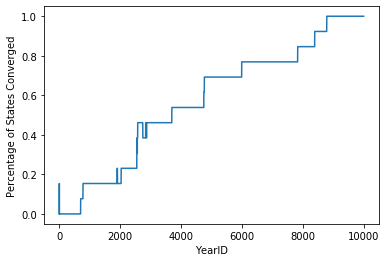

In [62]:
plt.plot(years[:], aal_table_grouped.loc[:, "Converged"])
plt.xlabel("YearID")
plt.ylabel("Percentage of States Converged")

The above plot shows the percentage of states whose catalog has converged by YearID.  It is a very odd looking plot, but it provides useful information and some insight into the convergence criterion itself.  The first thing to note: roughly twenty percent of our catalog meets the convergence criterion after just a few years.  Unfortunately, that percentage almost immediately drops to zero.  This underscores the statistical nature of the coefficient of variation.  For each year, we are estimating the coefficient of variation from a set of random samples.  If the random samples themselves change, then the estimate of the coefficient of variation will change as well.  This variation may cause the coefficient to oscillate above and below the threshold for convergence.  Thus, adding a new datapoint by considering an additional year may change our belief about the catalog's convergence.

Here we only have 13 states, which is a fairly small sample size for estimating the percentage of states converged.  In addition, the coefficient of variation is a function of YearID.  It is likely to be highly sensitive to the data at low YearID counts, due to the limited datasize.  As the number of years in the catalog increase, we should expect the variability to decrease due to the law of large numbers.

Lets bundle this analysis into a function so that we can analyze the convergence by county.

In [63]:
def perform_analysis_on_partitioned_catalog(fileset):
    full_dataset = pd.concat([read_and_reduce_dataset(file) for file in fileset], ignore_index = True)
    loss_table   = pd.pivot_table(full_dataset.drop('CrestaCode', axis = 1), index = "YearID", columns = "StateID", values = "GroundUpLoss",aggfunc = np.sum)
    loss_table   = loss_table.fillna(0)    
    
    aal_tab_set = [create_loss_statistic_table(loss_table.loc[:, col]) for col in loss_table.columns]
    aal_tab     = pd.concat(aal_tab_set) # keeps original row index
    
    aal_tab["Converged"] = aal_tab.loc[:,"COV"] < 0.05
    aal_tab["Converged"] = aal_tab["Converged"].astype(int) # convert true/false to 0/1
    
    aal_tab.loc[1, "Converged"] = 0     
    
    aal_tab_grouped = aal_tab.groupby(aal_tab.index).mean()
    print(aal_tab_grouped)
    return(aal_tab_grouped)


In [64]:
start_time = time.time()
output = perform_analysis_on_partitioned_catalog(fileset)
print("Processing the 10K catalog took %f seconds"%(time.time() - start_time))

output.head()

                AAL           STD        STDERR       COV  Converged
1      2.939209e+08  0.000000e+00  0.000000e+00  0.000000   0.000000
2      1.811761e+08  1.743787e+08  1.233044e+08  0.684941   0.153846
3      1.466049e+08  1.745471e+08  1.007748e+08  0.668564   0.000000
4      1.549620e+08  2.003918e+08  1.001959e+08  0.652877   0.000000
5      1.617798e+08  2.005383e+08  8.968345e+07  0.689452   0.000000
...             ...           ...           ...       ...        ...
9996   2.674755e+08  5.496094e+08  5.497193e+06  0.031967   1.000000
9997   2.674688e+08  5.495828e+08  5.496653e+06  0.031966   1.000000
9998   2.674861e+08  5.495690e+08  5.496240e+06  0.031964   1.000000
9999   2.674802e+08  5.495440e+08  5.495715e+06  0.031963   1.000000
10000  2.674681e+08  5.495184e+08  5.495184e+06  0.031962   1.000000

[10000 rows x 5 columns]
Processing the 10K catalog took 7.803656 seconds


,AAL,STD,STDERR,COV,Converged
1,2.939209e+08,0.000000e+00,0.000000e+00,0.000000,0.000000
2,1.811761e+08,1.743787e+08,1.233044e+08,0.684941,0.153846
3,1.466049e+08,1.745471e+08,1.007748e+08,0.668564,0.000000
4,1.549620e+08,2.003918e+08,1.001959e+08,0.652877,0.000000
5,1.617798e+08,2.005383e+08,8.968345e+07,0.689452,0.000000


Text(0.5, 1.0, '10k Year Catalog')

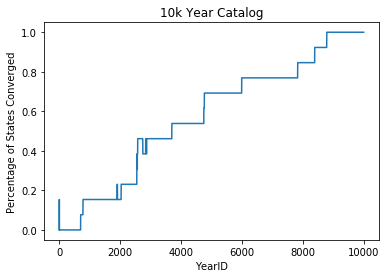

In [69]:
# And now we can verify that our output is still the same as before.
plt.plot(years, output.Converged)
plt.xlabel("YearID")
plt.ylabel("Percentage of States Converged")
plt.title("10k Year Catalog")

Lets try this with the 100K catalog.

In [67]:
dataset_path_prefix_100 = "./100K/Unfiltered_100k_20190919_part_"

num_files_100 = 100           # number of parts the dataset is partitioned into

num_catalog_years_100 = 100000

fileset_100 = ["%s%d.csv"%(dataset_path_prefix_100, index) for index in np.arange(1, num_files_100 + 1)]

In [68]:
start_time = time.time()
output_100k = perform_analysis_on_partitioned_catalog(fileset_100)
print("Processing the 100K catalog took %s seconds"%( (time.time() - start_time)) )

output_100k.head()

                 AAL           STD        STDERR       COV  Converged
1       3.014223e+08  0.000000e+00  0.000000e+00  0.000000   0.000000
2       1.883073e+08  1.713907e+08  1.211915e+08  0.677422   0.076923
3       1.765957e+08  1.769188e+08  1.021441e+08  0.708341   0.000000
4       2.057774e+08  1.928237e+08  9.641187e+07  0.653611   0.000000
5       2.033838e+08  1.809004e+08  8.090111e+07  0.520041   0.000000
...              ...           ...           ...       ...        ...
99996   4.098960e+08  7.034156e+08  2.224440e+06  0.007380   1.000000
99997   4.098979e+08  7.034139e+08  2.224424e+06  0.007380   1.000000
99998   4.099023e+08  7.034150e+08  2.224416e+06  0.007380   1.000000
99999   4.099005e+08  7.034122e+08  2.224396e+06  0.007380   1.000000
100000  4.098987e+08  7.034092e+08  2.224375e+06  0.007380   1.000000

[100000 rows x 5 columns]
Processing the 100K catalog took 164.4024531841278 seconds


,AAL,STD,STDERR,COV,Converged
1,3.014223e+08,0.000000e+00,0.000000e+00,0.000000,0.000000
2,1.883073e+08,1.713907e+08,1.211915e+08,0.677422,0.076923
3,1.765957e+08,1.769188e+08,1.021441e+08,0.708341,0.000000
4,2.057774e+08,1.928237e+08,9.641187e+07,0.653611,0.000000
5,2.033838e+08,1.809004e+08,8.090111e+07,0.520041,0.000000


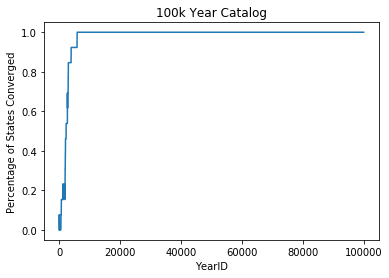

In [70]:
years = np.arange(1, num_catalog_years_100 + 1)
plt.plot(years, output_100k.Converged)
plt.xlabel("YearID")
plt.ylabel("Percentage of States Converged")
plt.title("100k Year Catalog")
plt.show()

Above, we have repeated our analysis from the 10K catalog using the 100K catalog.  In the original set, convergence was reached prior to YearID 10,000.  The process for constructing the catalog is stochastic, so the event generation is random.  As a result, there will be some variability due to the stochastic nature of the simulation.  However, if the catalog was truely converged by YearID 10,000, then we would expect that any catalog that extends past 10,000 years should converge as well.  We should be careful when reading the phrase "any catalog ..."  Specifically, I mean that any random repetition of the same sampling procedure should be of similar quality to the catalog that we just studied.  That means considering the same states, the same climate, and the same peril.  A 10K catalog for atlantic hurricanes may converge for the eastern cost of the united states, however it may not converge for earthquakes on the east coast.  This analysis specifically applies to the simulation that we are currently considering.

To underscore this point, let us consider the convergence of the same catalog by county, rather than by state.

In [71]:
def perform_analysis_on_partitioned_catalog_by_county(fileset):
    full_dataset = pd.concat([read_and_reduce_dataset(file) for file in fileset], ignore_index = True)
    loss_table   = pd.pivot_table(full_dataset.drop('StateID', axis = 1), index = "YearID", columns = "CrestaCode", values = "GroundUpLoss",aggfunc = np.sum)
    loss_table   = loss_table.fillna(0)    
    
    aal_tab_set = [create_loss_statistic_table(loss_table.loc[:, col]) for col in loss_table.columns]
    aal_tab     = pd.concat(aal_tab_set) # keeps original row index
    
    aal_tab["Converged"] = aal_tab.loc[:,"COV"] < 0.05
    aal_tab["Converged"] = aal_tab["Converged"].astype(int) # convert true/false to 0/1
    
    aal_tab.loc[1, "Converged"] = 0     
    
    aal_tab_grouped = aal_tab.groupby(aal_tab.index).mean()
    print(aal_tab_grouped)
    return(aal_tab_grouped)

In [72]:
start_time = time.time()
output_10k_by_county = perform_analysis_on_partitioned_catalog_by_county(fileset)

print("Processing the 10K catalog took %f seconds"%(time.time() - start_time))

                AAL           STD        STDERR       COV  Converged
1      5.156507e+06  0.000000e+00  0.000000e+00  0.000000   0.000000
2      3.178527e+06  4.379023e+06  3.096437e+06  0.104242   0.892038
3      2.572016e+06  4.331223e+06  2.500633e+06  0.169337   0.823212
4      2.718632e+06  5.224564e+06  2.612282e+06  0.197973   0.790823
5      2.838241e+06  6.024756e+06  2.694353e+06  0.222826   0.763833
...             ...           ...           ...       ...        ...
9996   4.692553e+06  3.223684e+07  3.224329e+05  0.188064   0.032389
9997   4.692435e+06  3.223544e+07  3.224027e+05  0.188059   0.032389
9998   4.692738e+06  3.223539e+07  3.223861e+05  0.188051   0.032389
9999   4.692634e+06  3.223420e+07  3.223581e+05  0.188050   0.032389
10000  4.692423e+06  3.223285e+07  3.223285e+05  0.188042   0.032389

[10000 rows x 5 columns]
Processing the 10K catalog took 14.605042 seconds


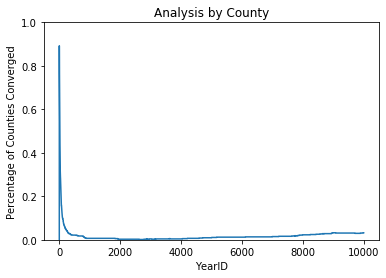

            AAL           STD        STDERR       COV  Converged
1  5.156507e+06  0.000000e+00  0.000000e+00  0.000000   0.000000
2  3.178527e+06  4.379023e+06  3.096437e+06  0.104242   0.892038
3  2.572016e+06  4.331223e+06  2.500633e+06  0.169337   0.823212
4  2.718632e+06  5.224564e+06  2.612282e+06  0.197973   0.790823
5  2.838241e+06  6.024756e+06  2.694353e+06  0.222826   0.763833


,AAL,STD,STDERR,COV,Converged
9996,4.692553e+06,3.223684e+07,322432.914107,0.188064,0.032389
9997,4.692435e+06,3.223544e+07,322402.739401,0.188059,0.032389
9998,4.692738e+06,3.223539e+07,322386.135185,0.188051,0.032389
9999,4.692634e+06,3.223420e+07,322358.132796,0.188050,0.032389
10000,4.692423e+06,3.223285e+07,322328.544825,0.188042,0.032389


In [80]:
plt.plot(np.arange(1, 10001), output_10k_by_county.Converged)
plt.ylim([0,1])
plt.xlabel("YearID")
plt.ylabel("Percentage of Counties Converged")
plt.title("Analysis by County")
plt.show()

print(output_10k_by_county.head())
output_10k_by_county.tail()

The analysis by county starts off promising, roughly 90 % of the catalog has converged by year 2!  However, looking at both the plot and the table, we see that this initial optimism is simply noise.  As the sample size grows, the trend starts to become clear: the percentage of counties that reach convergence starts very low, and steadily increases with YearID.  Unfortunately, this steady increase stops at a very low value.  Roughly 97 percent of the catalog fails to converge by 10,000 years.

We changed the parameters by which we did our analysis, and thus the results changed as well.  We are trying to estimate rare event probabilities using random sampling.  An event that occurs once every 10 years will be expected to occur 1,000 times in a 10K catalog.  Of course, the random nature of the process means that a specific catalog may only have 950 of those events occur.  If that occurs, we would estimate the event probability as 0.095 rather than the actual value of 0.1.  Let's check the relative error.

In [84]:
true_value = 0.1

estimated_value = 0.095

relative_error = 100*abs(true_value - estimated_value)/true_value

relative_error

5.000000000000004

This gives us a relative error of roughly five percent, which may not bee too bad for performing analysis with.  However, if we consider an event that occurs only once every twenty thousand years, we might not even get a single event in our catalog to estimate that probability.  In addition, the variance of our estimate is likely to be large due to the relatively small sample size.  

This gives us a chance to reflect on what has changed from the state based analysis to the county based analysis: the spatial extent of a county versus a state.  For now, consider hurricanes that impact Richland County in the state of South Carolina.  Because Richland county is contained in the state of South Carolina, any hurricane that impacts Richland county also impacts South Carolina.  However, there are many possible hurricane paths that would impact South Carolina without crossing the boundary of Richland county.  Thus, the probability of a hurricane striking Richland County is smaller than the probability of a hurricane striking South Carolina.

By considering a smaller spatial resolution, we are attempting to estimate much smaller probabilities using the same random sampling procedure.  The sample size used to estimate those rare event probabilities needs to be increased in order to have any confidence in our estimates.  So, let's repeat our analysis on the 100K catalog and see how much of an impact the larger sample size will make.

In [85]:
start_time = time.time()
output_100k_by_county = perform_analysis_on_partitioned_catalog_by_county(fileset_100)
print("Processing the 100K catalog took %f minutes"%((time.time() - start_time)/60))


                 AAL           STD        STDERR       COV  Converged
1       5.288111e+06  0.000000e+00  0.000000e+00  0.000000   0.000000
2       3.303637e+06  3.805790e+06  2.691100e+06  0.184406   0.800270
3       3.098170e+06  4.177291e+06  2.411760e+06  0.270227   0.700405
4       3.610130e+06  5.598642e+06  2.799321e+06  0.310611   0.654521
5       3.568137e+06  6.020551e+06  2.692472e+06  0.333339   0.627530
...              ...           ...           ...       ...        ...
99996   7.191158e+06  4.059376e+07  1.283713e+05  0.045573   0.713900
99997   7.191192e+06  4.059373e+07  1.283706e+05  0.045572   0.713900
99998   7.191269e+06  4.059446e+07  1.283722e+05  0.045572   0.713900
99999   7.191236e+06  4.059439e+07  1.283714e+05  0.045572   0.713900
100000  7.191206e+06  4.059425e+07  1.283703e+05  0.045572   0.713900

[100000 rows x 5 columns]
Processing the 100K catalog took 3.798837 minutes


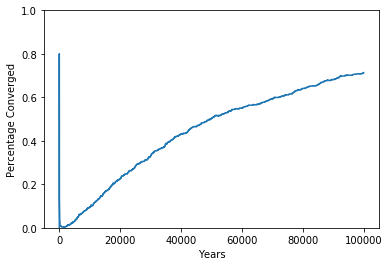

,AAL,STD,STDERR,COV,Converged
1,2.939209e+08,0.000000e+00,0.000000e+00,0.000000,0.000000
2,1.811761e+08,1.743787e+08,1.233044e+08,0.684941,0.153846
3,1.466049e+08,1.745471e+08,1.007748e+08,0.668564,0.000000
4,1.549620e+08,2.003918e+08,1.001959e+08,0.652877,0.000000
5,1.617798e+08,2.005383e+08,8.968345e+07,0.689452,0.000000


In [87]:
plt.plot(np.arange(1, 100001), output_100k_by_county.Converged)
plt.ylim([0,1])
plt.xlabel("Years")
plt.ylabel("Percentage Converged")
plt.show()

output.head()